# - TÍTULO: Casos de hospitalização por INFLUENZA (H3N2) durante a pandemia de COVID-19

# - PARTE 2

## - SCRIPT PARA: CRIAÇÃO DE MODELO DE MACHINE LEARING | INTERPRETAÇÃO DOS RESULTADOS

### Importação das bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import imblearn
from sklearn import metrics                             
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from matplotlib import rc
%matplotlib inline
from imblearn.under_sampling import NearMiss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier         
from sklearn.neighbors import KNeighborsClassifier      
from sklearn.linear_model import LogisticRegression     
from sklearn.ensemble import RandomForestClassifier     
from sklearn import model_selection                     
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, confusion_matrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

# Importação do banco de dados

In [2]:
SAMPLE_SET = r'......\datasets\SAMPLE_SET.csv'
SAMPLE_SET = pd.read_csv(SAMPLE_SET, index_col=0)
SAMPLE_SET.rename(columns={'CLASSI_FIN':'target'}, inplace=True)
print (SAMPLE_SET)
SAMPLE_SET.shape

       FEBRE  TOSSE  GARGANTA  DISPNEIA  DESC_RESP  SATURACAO  DIARREIA  \
0        1.0    0.0       0.0       0.0        0.0        0.0       1.0   
1        0.0    0.0       0.0       0.0        1.0        1.0       0.0   
2        0.0    1.0       1.0       1.0        0.0        0.0       0.0   
3        0.0    0.0       0.0       1.0        1.0        1.0       0.0   
4        0.0    1.0       0.0       0.0        0.0        0.0       0.0   
...      ...    ...       ...       ...        ...        ...       ...   
54831    0.0    1.0       0.0       1.0        1.0        1.0       0.0   
54832    1.0    1.0       0.0       0.0        0.0        0.0       0.0   
54833    0.0    1.0       0.0       1.0        1.0        1.0       0.0   
54834    0.0    0.0       0.0       0.0        1.0        1.0       0.0   
54835    0.0    1.0       0.0       1.0        1.0        0.0       0.0   

       VOMITO  OUTRO_SIN  target  DOR_ABD  FADIGA  PERD_OLFT  PERD_PALA  2010  
0         0.0      

(54836, 15)

In [3]:
col = SAMPLE_SET.pop("target")
SAMPLE_SET.insert(0, col.name, col)
df = SAMPLE_SET
df

,target,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,2010
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54831,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54832,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
54833,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54834,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


## SEPARANDO OS SINTOMAS DA VARIÁVEL DE CLASSIFICAÇÃO (target)

In [4]:
X = df.drop("target", axis = 1)
y = df.target
xshape, yshape = df.shape
print("O dataframe possui {} amostras (linhas) e {} variáveis (colunas)".format(xshape,yshape))

O dataframe possui 54836 amostras (linhas) e 15 variáveis (colunas)


## GRÁFICO DE DISTRIBUIÇÃO DA VARIÁVEL DE CLASSIFICAÇÃO: 0.0 (INFLUENZA) E DA VARIÁVEL 1.0 (COVID-19)

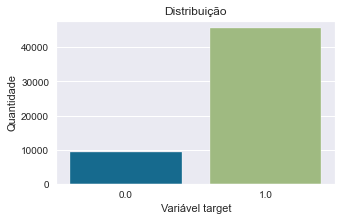

In [5]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize = (5, 3))
    ax = sns.countplot('target', data=df);
    plt.title("Distribuição")
    plt.xlabel("Variável target")
    plt.ylabel("Quantidade")

## 4 CRIAÇÃO DE MODELO DE MACHINE LEARING

In [6]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.25, random_state=5)

In [7]:
x_treino1 = x_treino
x_teste1 = x_teste
y_treino1 = y_treino
y_teste1 = y_teste

## 4.1 REALIZA-SE O TESTE COM TODO ESPAÇO AMOSTRAL

In [8]:
print (f'x_treino: ', x_treino.shape)
print (f'x_teste: ', x_teste.shape)
print (f'y_treino: ', y_treino.shape)
print (f'y_teste: ', y_teste.shape)

x_treino:  (41127, 14)
x_teste:  (13709, 14)
y_treino:  (41127,)
y_teste:  (13709,)


In [9]:
def avalia_metricas(y_teste, previsoes, nome_modelo):
    print(nome_modelo)
    
    report = classification_report(y_teste, previsoes)
    print(report)
    
    precisao = accuracy_score(y_teste, previsoes)
    print("Acurácia de: ", precisao)
    
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, previsoes), 
                             index=["TRUE - H3N2","TRUE - COVID"], 
                             columns=["PREDICTED - H3N2","PREDICTED - COVID"])
    
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    print("#" * 50)

### 4.1.1 CLASSIFICAÇÃO COM: Árvore de decisão | Random Forest | KNN (K-Nearest Neighbors) | Regressão Logística

In [10]:
classificadores = {
    "DecisionTree": DecisionTreeClassifier(random_state=5),
    "RandomForest": RandomForestClassifier(random_state=5),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(random_state=5)}

### 4.1.2 MATRIZ DE CONFUSÃO AVALIANDO OS MODELOS DE MACHINE LEARNING

DecisionTree
              precision    recall  f1-score   support

         0.0       0.22      0.03      0.05      2270
         1.0       0.84      0.98      0.90     11439

    accuracy                           0.82     13709
   macro avg       0.53      0.50      0.47     13709
weighted avg       0.73      0.82      0.76     13709

Acurácia de:  0.8236924648041433


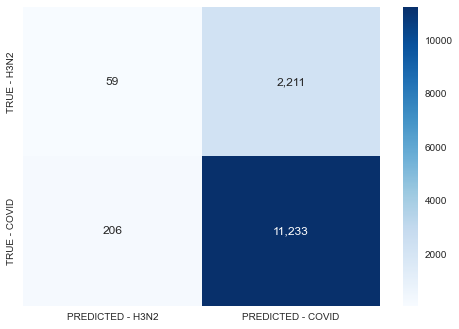

##################################################
RandomForest
              precision    recall  f1-score   support

         0.0       0.31      0.02      0.03      2270
         1.0       0.84      0.99      0.91     11439

    accuracy                           0.83     13709
   macro avg       0.57      0.50      0.47     13709
weighted avg       0.75      0.83      0.76     13709

Acurácia de:  0.8308410533226348


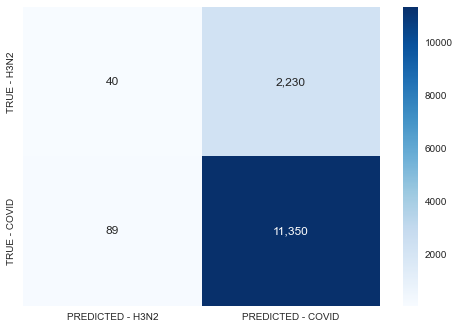

##################################################
KNN
              precision    recall  f1-score   support

         0.0       0.17      0.07      0.10      2270
         1.0       0.83      0.93      0.88     11439

    accuracy                           0.79     13709
   macro avg       0.50      0.50      0.49     13709
weighted avg       0.73      0.79      0.75     13709

Acurácia de:  0.7905025895397184


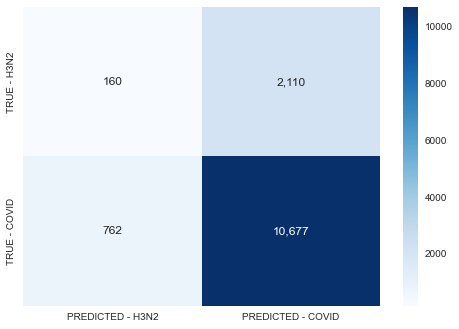

##################################################
LogisticRegression
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2270
         1.0       0.83      1.00      0.91     11439

    accuracy                           0.83     13709
   macro avg       0.42      0.50      0.45     13709
weighted avg       0.70      0.83      0.76     13709

Acurácia de:  0.8344153475818805


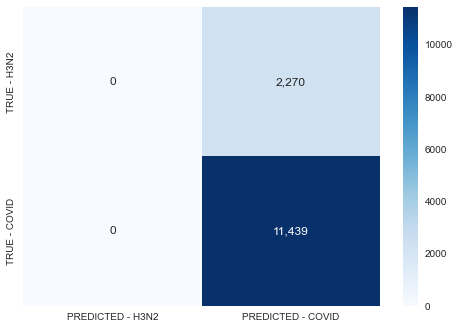

##################################################


In [11]:
for nome_modelo in classificadores:
    modelo = classificadores[nome_modelo]
    modelo.fit(x_treino, y_treino)
    previsoes = modelo.predict(x_teste)
    avalia_metricas(y_teste, previsoes, nome_modelo)
    classificadores[nome_modelo] = modelo

## 4.2 PERCEBE-SE QUE O ALGORITMO IDENTIFICA MUITAS AMOSTRAS DA CLASSE COVID (CLASSE MAJORITÁRIA) E POUCA DA CLASSE INFLUENZA (CLASSE MINORITÁRIA)

## 4.3 PARA CORREÇÃO DESSE FATO É NECESSÁRIO FAZER O BALANCEAMENTO DA CLASSES E PARA ISSO FOI UTILIZADO A FUNÇÃO NEARMISS PELA BIBLIOTECA IMBLEARN

In [12]:
#from imblearn.under_sampling import NearMiss
nr = NearMiss(sampling_strategy='auto', version=1, n_neighbors=1, n_neighbors_ver3=1, n_jobs=8)
X, y = nr.fit_resample(X, y)

### 4.3.1 O BALANCEAMENTO DAS CLASSES SE DÁ A PARTIR DA SELEÇÃO ALEATÓRIA DE AMOSTRAS DA CLASSE MAJORITÁRIA EQUIVALENDO A QUANTIDADE DE AMOSTRAS DA CLASSE MINORITÁRIA, COMO DEMONSTRA O GRÁFICO A SEGUIR:

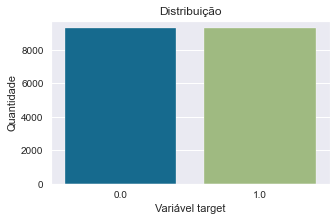

In [13]:
with sns.axes_style("darkgrid"):

#plt.style.use("ggplot")
    plt.figure(figsize = (5, 3))
    ax = sns.countplot(x=y)
    plt.title("Distribuição")
    plt.xlabel("Variável target")
    plt.ylabel("Quantidade")

## 4.4 REPETE-SE O PROCEDIMENTO COM O BANCO DE DADOS BALANCEADO

In [14]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.25, random_state=5)


In [15]:
print (f'x_treino: ', x_treino.shape)
print (f'x_teste: ', x_teste.shape)
print (f'y_treino: ', y_treino.shape)
print (f'y_teste: ', y_teste.shape)

x_treino:  (13909, 14)
x_teste:  (4637, 14)
y_treino:  (13909,)
y_teste:  (4637,)


In [16]:
def avalia_metricas(y_teste, previsoes, nome_modelo):
    print(nome_modelo)
    
    report = classification_report(y_teste, previsoes)
    print(report)
    
    precisao = accuracy_score(y_teste, previsoes)
    print("Acurácia de: ", precisao)
    
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, previsoes), 
                             index=["TRUE - H3N2","TRUE - COVID"], 
                             columns=["PREDICTED - H3N2","PREDICTED - COVID"])
    
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    print("#" * 50)

In [17]:
classificadores = {
    "DecisionTree": DecisionTreeClassifier(random_state=5),
    "RandomForest": RandomForestClassifier(random_state=5),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(random_state=5)}

# 4.4.1 MATRIZ DE CONFUSÃO COM O BANCO DE DADOS BALANCEADO

DecisionTree
              precision    recall  f1-score   support

         0.0       0.80      0.62      0.70      2303
         1.0       0.69      0.84      0.76      2334

    accuracy                           0.73      4637
   macro avg       0.75      0.73      0.73      4637
weighted avg       0.75      0.73      0.73      4637

Acurácia de:  0.7340953202501618


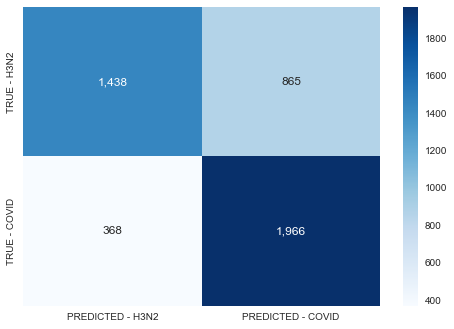

##################################################
RandomForest
              precision    recall  f1-score   support

         0.0       0.81      0.61      0.70      2303
         1.0       0.69      0.86      0.77      2334

    accuracy                           0.74      4637
   macro avg       0.75      0.73      0.73      4637
weighted avg       0.75      0.74      0.73      4637

Acurácia de:  0.7353892602976062


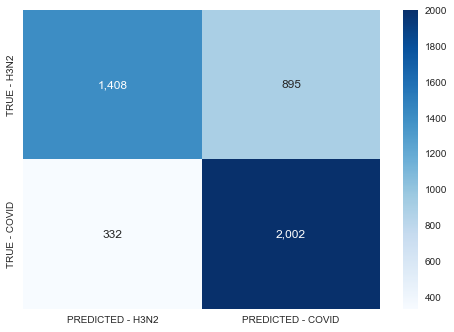

##################################################
KNN
              precision    recall  f1-score   support

         0.0       0.71      0.67      0.69      2303
         1.0       0.69      0.73      0.71      2334

    accuracy                           0.70      4637
   macro avg       0.70      0.70      0.70      4637
weighted avg       0.70      0.70      0.70      4637

Acurácia de:  0.6987276256200129


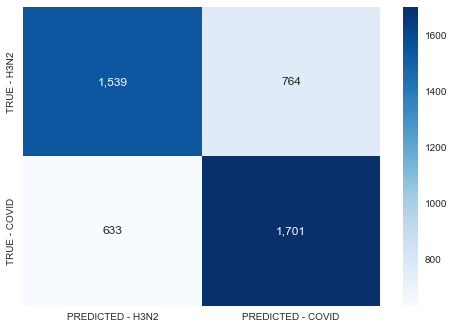

##################################################
LogisticRegression
              precision    recall  f1-score   support

         0.0       0.83      0.61      0.70      2303
         1.0       0.69      0.88      0.78      2334

    accuracy                           0.74      4637
   macro avg       0.76      0.74      0.74      4637
weighted avg       0.76      0.74      0.74      4637

Acurácia de:  0.7435842139314212


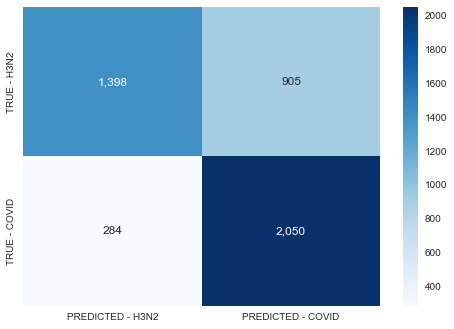

##################################################


In [18]:
# Teste dos algoritmos e visualização da Acurácia e Matriz de Confusão
for nome_modelo in classificadores:
    modelo = classificadores[nome_modelo]
    modelo.fit(x_treino, y_treino)
    previsoes = modelo.predict(x_teste)
    avalia_metricas(y_teste, previsoes, nome_modelo)
    classificadores[nome_modelo] = modelo

In [19]:
X_df = np.concatenate((x_treino, x_teste), axis = 0)
X_df.shape

(18546, 14)

In [20]:
Y_df = np.concatenate((y_treino, y_teste), axis = 0)
Y_df.shape

(18546,)

# 4.5 MODEL TUNING COM GridSearchCV

In [21]:
parametros = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}

In [22]:
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parametros)
grid_search.fit(X_df, Y_df)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
0.7358461351749478


In [23]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 40, 100, 150],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}

In [24]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(X_df, Y_df)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'entropy', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.7444195259000653


In [25]:
parametros = {'n_neighbors': [3, 5, 10, 20],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}

In [26]:
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parametros)
grid_search.fit(X_df, Y_df)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'algorithm': 'brute', 'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
0.7326109797760092


In [27]:
parametros = {'tol': [0.0001, 0.00001, 0.000001],
              'C': [0.5, 1.0, 1.5, 2.0],
              'solver': ['lbfgs', 'sag', 'saga'],
              'multi_class': ['auto', 'ovr', 'multinomial']}

In [28]:
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=parametros)
grid_search.fit(X_df, Y_df)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'C': 1.0, 'multi_class': 'multinomial', 'solver': 'lbfgs', 'tol': 0.0001}
0.7383802784659446


# 4.6 K-fold Cross Validation

In [29]:
resultados_arvore = []
resultados_random_forest = []
resultados_knn = []
resultados_logistica = []
for i in range(30):
    print(i)
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    
    arvore = DecisionTreeClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=2, splitter='random')
    scores = cross_val_score(arvore, X_df, Y_df, cv = kfold)
    resultados_arvore.append(scores.mean())
    
    random_forest = RandomForestClassifier(criterion = 'entropy', min_samples_leaf=10, min_samples_split=5, n_estimators=40)
    scores = cross_val_score(random_forest, X_df, Y_df, cv = kfold)
    resultados_random_forest.append(scores.mean())
    
    knn = KNeighborsClassifier(algorithm='brute', n_neighbors=20, p=1, weights='uniform')
    scores = cross_val_score(knn, X_df, Y_df, cv = kfold)
    resultados_knn.append(scores.mean())
    
    logistica = LogisticRegression(C = 1.0, multi_class = 'multinomial', solver = 'sag', tol = 0.0001)
    scores = cross_val_score(logistica, X_df, Y_df, cv = kfold)
    resultados_logistica.append(scores.mean())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


## RESULTADOS INDIVIDUAIS DOS MODELOS DE MACHINE LEARNING POR FOLD

In [30]:
resultados = pd.DataFrame({'Arvore': resultados_arvore, 'Random forest': resultados_random_forest,
                           'KNN': resultados_knn, 'Logistica': resultados_logistica})
resultados

,Arvore,Random forest,KNN,Logistica
0,0.736762,0.742262,0.731263,0.739242
1,0.736276,0.742370,0.730077,0.738218
2,0.737409,0.743287,0.730939,0.738973
3,0.739134,0.743610,0.731264,0.738757
4,0.736438,0.743393,0.727757,0.737732
5,0.735899,0.742315,0.731046,0.738433
6,0.735361,0.742964,0.729538,0.738219
7,0.738058,0.742857,0.731749,0.738435
8,0.736816,0.742478,0.731154,0.738326
9,0.737841,0.742208,0.730671,0.738812


## MÉDIA DE DESEMPENHO DOS MODELOS DE MACHINE LEARNING

In [31]:
resultados.mean()

Arvore           0.736631
Random forest    0.742496
KNN              0.729649
Logistica        0.738398
dtype: float64

## 4.6.1 TODOS OS RESULTADOS TIVERAM UM PERFORMANCE BEM PARECIDA, ALTERANDO APENAS OS VALORES DE RECALL, F1-SCORE. ESTES VALORES QUE SE ALTERAM DE MODELO PARA MODELO SÃO IMPORTANTES PARA SELEÇÃO DO MELHOR MODELO

[Text(0, 0, 'Arvore'),
 Text(1, 0, 'Random forest'),
 Text(2, 0, 'KNN'),
 Text(3, 0, 'Logistica')]

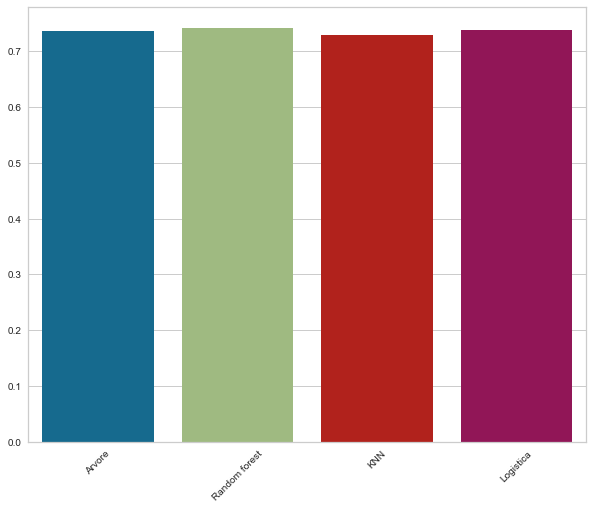

In [32]:
# Plotando o Gráfico dos Resultados
plt.figure(figsize=(10,8))
plot_resultado = sns.barplot(data=resultados)
plot_resultado.set_xticklabels(plot_resultado.get_xticklabels(),rotation=45)

In [33]:
resultados.describe()

,Arvore,Random forest,KNN,Logistica
count,30.000000,30.000000,30.000000,30.000000
mean,0.736631,0.742496,0.729649,0.738398
std,0.000987,0.001112,0.001387,0.000382
min,0.734066,0.739081,0.726141,0.737464
25%,0.736236,0.742221,0.729052,0.738178
50%,0.736628,0.742748,0.729564,0.738380
75%,0.737086,0.743219,0.730711,0.738651
max,0.739134,0.744150,0.731749,0.739242


# 5 INTERPRETAÇÃO DOS RESULTADOS

## 5.1 - Teste de normalidade nos resultados


In [34]:
alpha = 0.05 # confiabilidade

# Verificará se as distribuições são normais ou não
# Se os valores P >= alpha (tais dados estão em distribuição NORMAL), caso contrário é NÃO NORMAL

shapiro(resultados_arvore), shapiro(resultados_random_forest), shapiro(resultados_knn), shapiro(resultados_logistica)

(ShapiroResult(statistic=0.9643955230712891, pvalue=0.3990567624568939),
 ShapiroResult(statistic=0.9036791324615479, pvalue=0.010344638489186764),
 ShapiroResult(statistic=0.947613000869751, pvalue=0.14586931467056274),
 ShapiroResult(statistic=0.989540696144104, pvalue=0.9886105060577393))

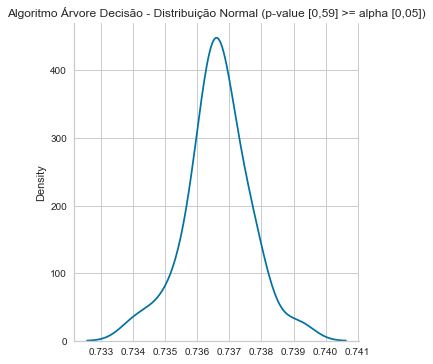

In [35]:
sns.displot(resultados_arvore, kind='kde'); # É DISTRIBUIÇÃO NORMAL
plt.title('Algoritmo Árvore Decisão - Distribuição Normal (p-value [0,59] >= alpha [0,05])', fontsize =12);

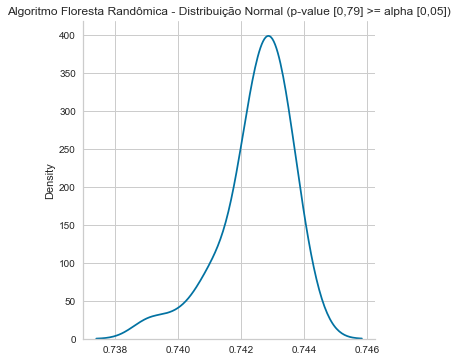

In [36]:
sns.displot(resultados_random_forest, kind='kde'); # É DISTRIBUIÇÃO NORMAL
plt.title('Algoritmo Floresta Randômica - Distribuição Normal (p-value [0,79] >= alpha [0,05])', fontsize =12);

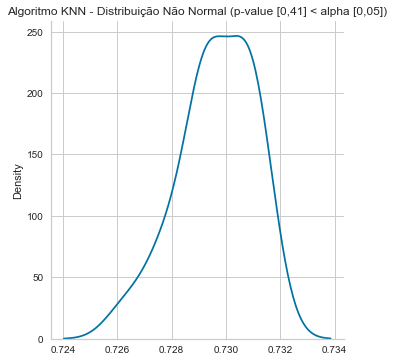

In [37]:
sns.displot(resultados_knn, kind='kde'); # É DISTRIBUIÇÃO NORMAL
plt.title('Algoritmo KNN - Distribuição Não Normal (p-value [0,41] < alpha [0,05])', fontsize =12);

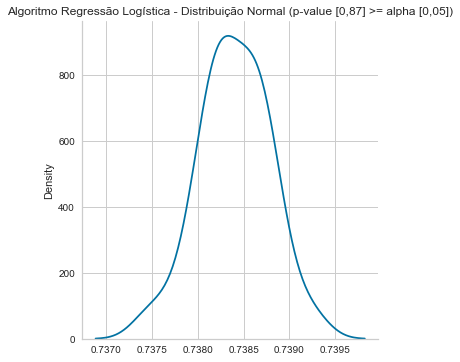

In [38]:
sns.displot(resultados_logistica, kind='kde'); # É DISTRIBUIÇÃO NORMAL
plt.title('Algoritmo Regressão Logística - Distribuição Normal (p-value [0,87] >= alpha [0,05])', fontsize =12);

## 5.2 - MODELOS DE MACHINE LEARNING PARAMETRIZADOS PELO GridSearchCV

In [39]:
arvore = DecisionTreeClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=2, splitter='random')
random_forest = RandomForestClassifier(criterion = 'gini', min_samples_leaf=10, min_samples_split=5, n_estimators=150)
knn = KNeighborsClassifier(algorithm='brute', n_neighbors=20, p=1, weights='uniform')
logistica = LogisticRegression(C = 2.0, multi_class = 'multinomial', solver = 'sag', tol = 0.0001)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


In [41]:
X_train

,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,2010
4217,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7506,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
18129,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
544,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18259,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6611,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9861,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4694,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9747,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 5.3 - CURVAS ROC

### A curva ROC é uma medida de desempenho para os problemas de classificação. Diz o quanto o modelo é capaz de distinguir entre as classes. Quanto mais acentuada é a curva, melhor será o modelo em prever 0 classes como 0 e 1 classe como 1. Por analogia, quanto mais acentuada é a curva, melhor será o modelo em distinguir entre enfermos hospitalizados com COVID-19 ou INFLUENZA.

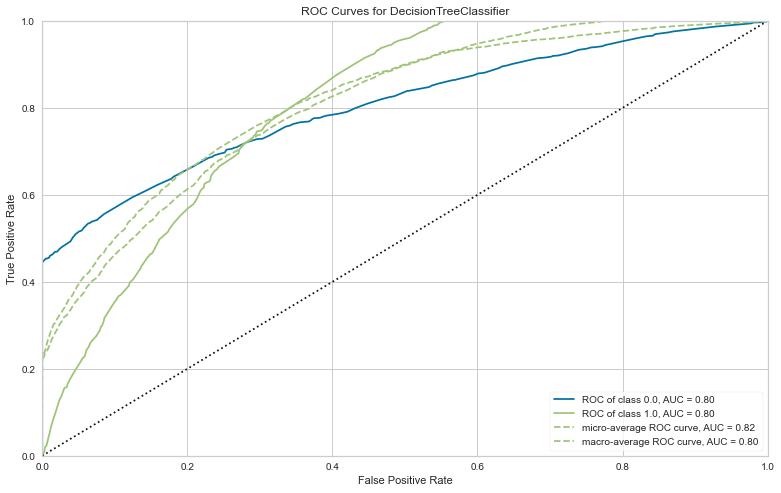

In [42]:
fig, ax = plt.subplots(figsize=(13,8))
visualizer = ROCAUC(DecisionTreeClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=2, splitter='random'), support=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

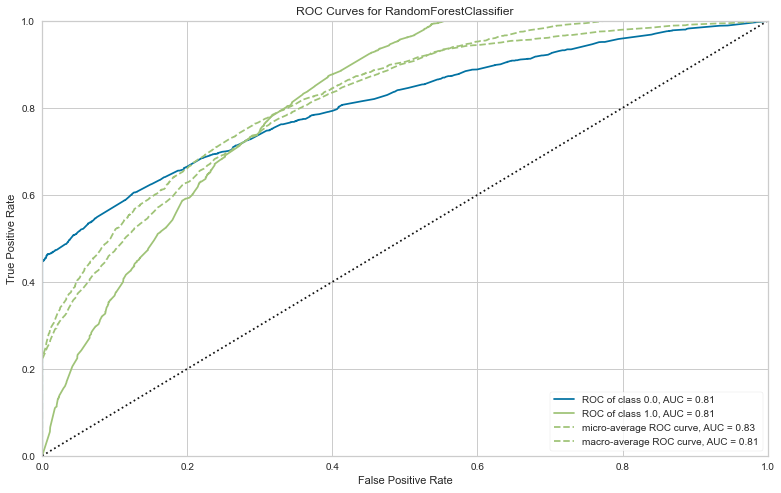

In [43]:
fig, ax = plt.subplots(figsize=(13,8))
visualizer = ROCAUC(RandomForestClassifier(criterion = 'gini', min_samples_leaf=10, min_samples_split=5, n_estimators=150), support=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

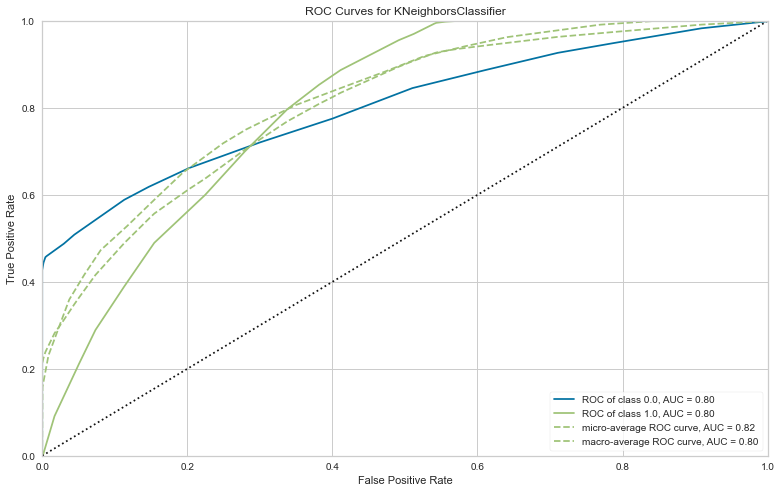

In [44]:
fig, ax = plt.subplots(figsize=(13,8))
visualizer = ROCAUC(KNeighborsClassifier(algorithm='brute', n_neighbors=20, p=1, weights='uniform'), support=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

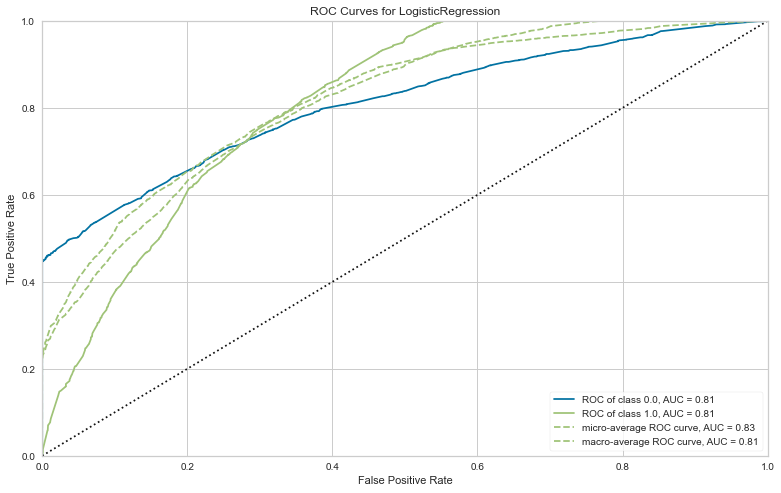

In [45]:
fig, ax = plt.subplots(figsize=(13,8))
visualizer = ROCAUC(LogisticRegression(C = 2.0, multi_class = 'multinomial', solver = 'sag', tol = 0.0001), support=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

# 6 Conclusão e Interpretação dos Resultados

## Foi possível avaliar positivamente esse algoritmo, podendo-se prever caso algum paciente, que fosse hospitalizado, precisasse de um 'diagnóstico artificial' a partir da análise dos sintomas presentes com urgência.

## Esse estudo ocorre do surgimento de uma grande disseminação de um tipo de Influenza (H3N2), durante a pandemia da COVID-19. O que sempre ocasionou a dúvida se a pessoa estava contamida por uma doença ou outra.

## Com este algoritmo é possível trazer esse 'diagnóstico artificial', com uma acurácia de cerca de 70% a partir dos sintomas registrados.